In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

### Early Stopping (versione semplice)

Implementazione minimalista: si ferma quando la validation loss smette di migliorare.

In [2]:
class SimpleEarlyStopping:
    """Versione semplice: si ferma appena la validation loss smette di migliorare."""
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.should_stop = False
    
    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            print(f"📊 Best val loss: {val_loss:.4f}")
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            print(f"✓ Migliorato! New best: {val_loss:.4f}")
        else:
            self.counter += 1
            print(f"⚠️ Nessun miglioramento ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.should_stop = True
                print(f"🛑 STOP! Nessun miglioramento per {self.patience} epoche")

print("✓ Classe SimpleEarlyStopping pronta!")

✓ Classe SimpleEarlyStopping pronta!


### Architettura MLP (classical Multilayer Perception)

In [3]:
# define neural network: Architecture MLP (classical Multilayer Perception)
class NeuralNetwork(nn.Module):
    def __init__(self, n1, n2, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()

        self.lin1 = nn.Linear(28*28, n1)
        self.act1 = nn.ReLU()

        self.lin2 = nn.Linear(n1, n2)
        self.act2 = nn.ReLU()

        self.output_layer = nn.Linear(n2, num_classes)

    def forward(self, x):
        x = self.flatten(x)  # (batch_size, 28, 28) => (batch_size, 28*28)

        # first layer (input is x, output is x1)
        x1 = self.lin1(x)
        x1 = self.act1(x1)

        # second layer (input is x1, output is x2)
        x2 = self.lin2(x1)
        x2 = self.act2(x2)

        # third/output layer (input is x2, output is logits)
        logits = self.output_layer(x2)
        return logits


In [4]:
from torchvision import datasets, transforms

# preprocessing to apply on each data sample:
# 1) convert to tensor
# 2) normalize images
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))  # Normalize a tensor image with mean and standard deviation.
        ])

# train dataset
train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
print(f"MNIST train dataset - num samples: {len(train_dataset)}")

# test dataset
test_dataset = datasets.MNIST('../data', train=False, transform=transform)
print(f"MNIST test dataset - num samples: {len(test_dataset)}")

MNIST train dataset - num samples: 60000
MNIST test dataset - num samples: 10000


In [5]:
from torch.utils.data import random_split

batch_size = 128  # we define here the batch size: number of samples processed before the model is updated

# Splitting training set into train and validation
train_size = int(0.9 * len(train_dataset))  # 90% for training
val_size = len(train_dataset) - train_size   # 10% for validation

# Create train and validation splits
train_dataset_split, val_dataset = random_split(
    train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

print(f"Training set size: {len(train_dataset_split)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset_split, 
    batch_size=batch_size, 
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

# Keep test loader as is
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False
)
print(f"Test set size: {len(test_dataset)}")


Training set size: 54000
Validation set size: 6000
Test set size: 10000


Training

In [6]:
# function for training
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # model to train mode
    train_loss = 0

    # ITERATE DATALOADER: train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        #  SINGLE OPTIMIZATION STEP IS PERFORMED ON A BATCH!
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = F.cross_entropy(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    # Return average loss
    avg_loss = train_loss / len(train_loader)
    return avg_loss

In [7]:
# test
# function for evaluation
def test(model, device, test_loader, dataset_name="Test"):
    model.eval()  # model to eval
    test_loss = 0
    correct = 0

    # ITERATE DATALOADER: test_loader
    for data, target in test_loader:
        batch_size = data.shape[0]
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # sanity check
        pred = pred.view(batch_size)  # [bs,]
        target = target.view(batch_size)  # [bs,]

        # compute prediction ok
        batch_pred_ok = pred.eq(target).sum().item()
        correct += batch_pred_ok

    test_loss /= len(test_loader.dataset)
    num_samples = len(test_loader.dataset)
    test_accuracy = correct / num_samples
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    print(f'\n{dataset_name} set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * test_accuracy:.2f}%)\n')
    return test_loss, (100. * test_accuracy)


In [8]:
learning_rate1 = 0.01
learning_rate2 = 0.1
learning_rate3 = 1

In [9]:
# Usa MPS per Mac (Apple Silicon) o CPU come fallback
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using MPS (Metal Performance Shaders) - Apple GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("✓ Using CUDA - NVIDIA GPU")
else:
    device = torch.device('cpu')
    print("✓ Using CPU")

    
# training hyperparameters
lr = learning_rate1
num_epochs = 30
print(f"lr: {lr}")
print(f"batch size: {batch_size}")
print(f"Num. optimization steps per-epoch: {int(len(train_dataset)/batch_size)}")

#########
# MODEL #
#########
model = NeuralNetwork(n1=512, n2=128, num_classes=10)
model = model.to(device)

#############
# OPTIMIZER #
#############
parameters_to_optimize = model.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=0.9)

✓ Using MPS (Metal Performance Shaders) - Apple GPU
lr: 0.01
batch size: 128
Num. optimization steps per-epoch: 468


### Esecuzione del Training 
in base all'architettura determinata

In [10]:
%%time
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

# Early stopping semplice
early_stop = SimpleEarlyStopping(patience=3)

# Training loop
for epoch in range(1, num_epochs + 1):
    # Train
    train_loss = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    
    # Validate
    val_loss, val_acc = test(model, device, val_loader, dataset_name="Validation")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Check early stopping
    early_stop.step(val_loss)
    if early_stop.should_stop:
        break

# Final test
test_loss, test_acc = test(model, device, test_loader, dataset_name="Test")
print(f"Final Test Accuracy: {test_acc:.2f}%")

Train Epoch: 1 [0/54000 (0%)]	Loss: 2.316961
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.666076
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.666076
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.329899
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.329899
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.305480
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.305480
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.333409
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.333409
Train Epoch: 1 [32000/54000 (59%)]	Loss: 0.361562
Train Epoch: 1 [32000/54000 (59%)]	Loss: 0.361562
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.295605
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.295605
Train Epoch: 1 [44800/54000 (83%)]	Loss: 0.223550
Train Epoch: 1 [44800/54000 (83%)]	Loss: 0.223550
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.164407
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.164407

Test set: Average loss: 0.2067, Accuracy: 5653/6000 (94%)


Validation set: Average loss: 0.2067, Accuracy: 5653/6000 (94.22%)

📊 Best val loss: 0.2067
Trai

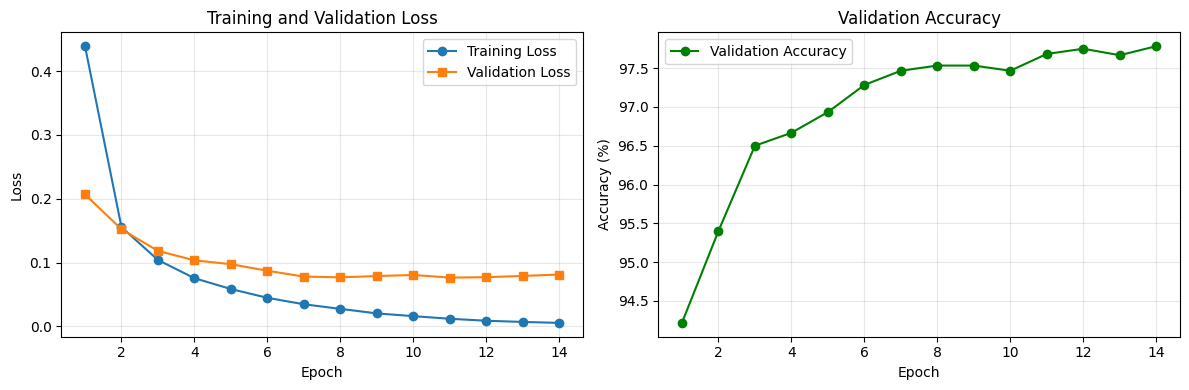

⚠️ Warning: Possible overfitting detected!
Recent avg train loss: 0.0098
Recent avg val loss: 0.0788


In [11]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot validation accuracy
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
if len(train_losses) > 5:
    recent_train = np.mean(train_losses[-5:])
    recent_val = np.mean(val_losses[-5:])
    if recent_val > recent_train * 1.2:
        print("⚠️ Warning: Possible overfitting detected!")
        print(f"Recent avg train loss: {recent_train:.4f}")
        print(f"Recent avg val loss: {recent_val:.4f}")

### Cambio architettura, uso di una CNN

In [13]:
# Define Convolutional Neural Network
class ConvolutionalNetwork(nn.Module):
    def __init__(self, n1, n2, num_classes):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, n1, kernel_size=3, padding=1)  # in_channels=1 for grayscale
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        
        self.conv2 = nn.Conv2d(n1, n2, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        
        # Calculate the size after convolutions and pooling
        # Input: 28x28 -> after first pool: 14x14 -> after second pool: 7x7
        # So we have n2 channels of 7x7 = n2 * 49
        
        self.flatten = nn.Flatten()
        
        # Fully connected layers (same structure as MLP)
        self.fc1 = nn.Linear(n2 * 7 * 7, n1)
        self.act3 = nn.ReLU()
        
        self.fc2 = nn.Linear(n1, n2)
        self.act4 = nn.ReLU()
        
        self.output_layer = nn.Linear(n2, num_classes)
    
    def forward(self, x):
        # Convolutional part
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        # Flatten for fully connected layers
        x = self.flatten(x)
        
        # Fully connected part
        x = self.fc1(x)
        x = self.act3(x)
        
        x = self.fc2(x)
        x = self.act4(x)
        
        logits = self.output_layer(x)
        return logits

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create both models with n1=64, n2=128
n1, n2 = 64, 128
num_classes = 10

# MLP
mlp_model = NeuralNetwork(n1=n1, n2=n2, num_classes=num_classes)
mlp_params = count_parameters(mlp_model)

# CNN
cnn_model = ConvolutionalNetwork(n1=n1, n2=n2, num_classes=num_classes)
cnn_params = count_parameters(cnn_model)

print(f"MLP parameters: {mlp_params:,}")
print(f"CNN parameters: {cnn_params:,}")

# Detailed breakdown for MLP
print("\nMLP Detailed:")
print(f"  Layer 1: 28*28 * {n1} + {n1} = {28*28*n1 + n1:,}")
print(f"  Layer 2: {n1} * {n2} + {n2} = {n1*n2 + n2:,}")
print(f"  Output:  {n2} * 10 + 10 = {n2*10 + 10:,}")

# Detailed breakdown for CNN
print("\nCNN Detailed:")
print(f"  Conv1: 1 * {n1} * 3 * 3 + {n1} = {1*n1*3*3 + n1:,}")
print(f"  Conv2: {n1} * {n2} * 3 * 3 + {n2} = {n1*n2*3*3 + n2:,}")
print(f"  FC1:   {n2} * 7 * 7 * {n1} + {n1} = {n2*7*7*n1 + n1:,}")
print(f"  FC2:   {n1} * {n2} + {n2} = {n1*n2 + n2:,}")
print(f"  Output: {n2} * 10 + 10 = {n2*10 + 10:,}")

MLP parameters: 59,850
CNN parameters: 485,578

MLP Detailed:
  Layer 1: 28*28 * 64 + 64 = 50,240
  Layer 2: 64 * 128 + 128 = 8,320
  Output:  128 * 10 + 10 = 1,290

CNN Detailed:
  Conv1: 1 * 64 * 3 * 3 + 64 = 640
  Conv2: 64 * 128 * 3 * 3 + 128 = 73,856
  FC1:   128 * 7 * 7 * 64 + 64 = 401,472
  FC2:   64 * 128 + 128 = 8,320
  Output: 128 * 10 + 10 = 1,290


In [15]:
# Invece di:
# model = NeuralNetwork(n1=512, n2=512, num_classes=10)

# Usa:
model = ConvolutionalNetwork(n1=64, n2=128, num_classes=10)
model = model.to(device)

# Il resto del codice rimane uguale
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

### Esecuzione del Training 
in base all'architettura determinata

In [16]:
%%time
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

# Early stopping semplice
early_stop = SimpleEarlyStopping(patience=3)

# Training loop
for epoch in range(1, num_epochs + 1):
    # Train
    train_loss = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(train_loss)
    
    # Validate
    val_loss, val_acc = test(model, device, val_loader, dataset_name="Validation")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Check early stopping
    early_stop.step(val_loss)
    if early_stop.should_stop:
        break

# Final test
test_loss, test_acc = test(model, device, test_loader, dataset_name="Test")
print(f"Final Test Accuracy: {test_acc:.2f}%")

Train Epoch: 1 [0/54000 (0%)]	Loss: 2.304986
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.583798
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.583798
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.197081
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.197081
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.145000
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.145000
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.148622
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.148622
Train Epoch: 1 [32000/54000 (59%)]	Loss: 0.132610
Train Epoch: 1 [32000/54000 (59%)]	Loss: 0.132610
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.147588
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.147588
Train Epoch: 1 [44800/54000 (83%)]	Loss: 0.113547
Train Epoch: 1 [44800/54000 (83%)]	Loss: 0.113547
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.073496
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.073496

Test set: Average loss: 0.1044, Accuracy: 5817/6000 (97%)


Validation set: Average loss: 0.1044, Accuracy: 5817/6000 (96.95%)

📊 Best val loss: 0.1044
Trai

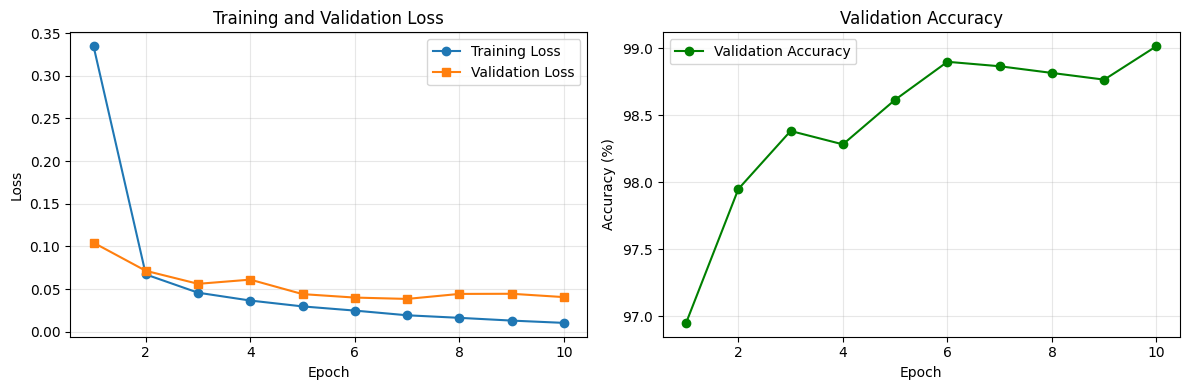

⚠️ Warning: Possible overfitting detected!
Recent avg train loss: 0.0169
Recent avg val loss: 0.0417


In [17]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot validation accuracy
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
if len(train_losses) > 5:
    recent_train = np.mean(train_losses[-5:])
    recent_val = np.mean(val_losses[-5:])
    if recent_val > recent_train * 1.2:
        print("⚠️ Warning: Possible overfitting detected!")
        print(f"Recent avg train loss: {recent_train:.4f}")
        print(f"Recent avg val loss: {recent_val:.4f}")